In [106]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [107]:
dir_name = "../results/piston__1000__70.00__0.01__6.28__1.00__0.00"
data_dir = dir_name + "/data/"

n_cells = 1000
data = pd.read_csv(data_dir + 'cell_params.txt', delimiter='\t', names=["t", 'x', 'r', 'u', 'p'], index_col=False)
# data['x'] = data.index
length = int(len(data.index) / n_cells)

GAMMA = 5. / 3
c_v = 8.31 / (GAMMA - 1)
# data['s'] = 1 + c_v * np.log(data['p'] / (data['r'] ** GAMMA))

filtered_data = data

sorted_data = data

In [108]:
data

,t,x,r,u,p
0,0.0002,0.161000,1.00000,0.000000,1.00000
1,0.0002,0.162000,1.00000,0.000000,1.00000
2,0.0002,0.163000,1.00000,0.000000,1.00000
3,0.0002,0.164000,1.00000,0.000000,1.00000
4,0.0002,0.165000,1.00000,0.000000,1.00000
...,...,...,...,...,...
279986,69.9501,0.355663,1.00151,-0.006921,1.00151
279987,69.9501,0.356665,1.00153,-0.006891,1.00153
279988,69.9501,0.357668,1.00155,-0.006860,1.00155
279989,69.9501,0.358670,1.00157,-0.006829,1.00157


In [109]:
t_min = sorted_data['t'].min()
t_max = sorted_data['t'].max()
t_interp = np.linspace(t_min, t_max, len(data['t'].unique()))
t_step = t_interp[1] - t_interp[0]

In [110]:
parameters = {'r' :  'density', 
             'p' : 'pressure', 
             'u' : 'velocity'}

In [111]:
parameter = 'p'

In [112]:
x_point = 0.26
r_interp = []
for t in t_interp:
    # выбрать ближайшие точки из отфильтрованных данных
    nearest_points = filtered_data[filtered_data['t'].between(t-t_step, t+t_step)]
#     print(nearest_points)
    # выполнить линейную интерполяцию значений r на выбранном интервале времени
    try:
        interp_func = interp1d(nearest_points['x'], nearest_points[parameter], kind='linear', fill_value="extrapolate")
    except ValueError:
        print(nearest_points)
        break
    r_at_x_point = interp_func(x_point)
    r_interp.append(r_at_x_point)
    
t_interp = t_interp[:len(r_interp)]

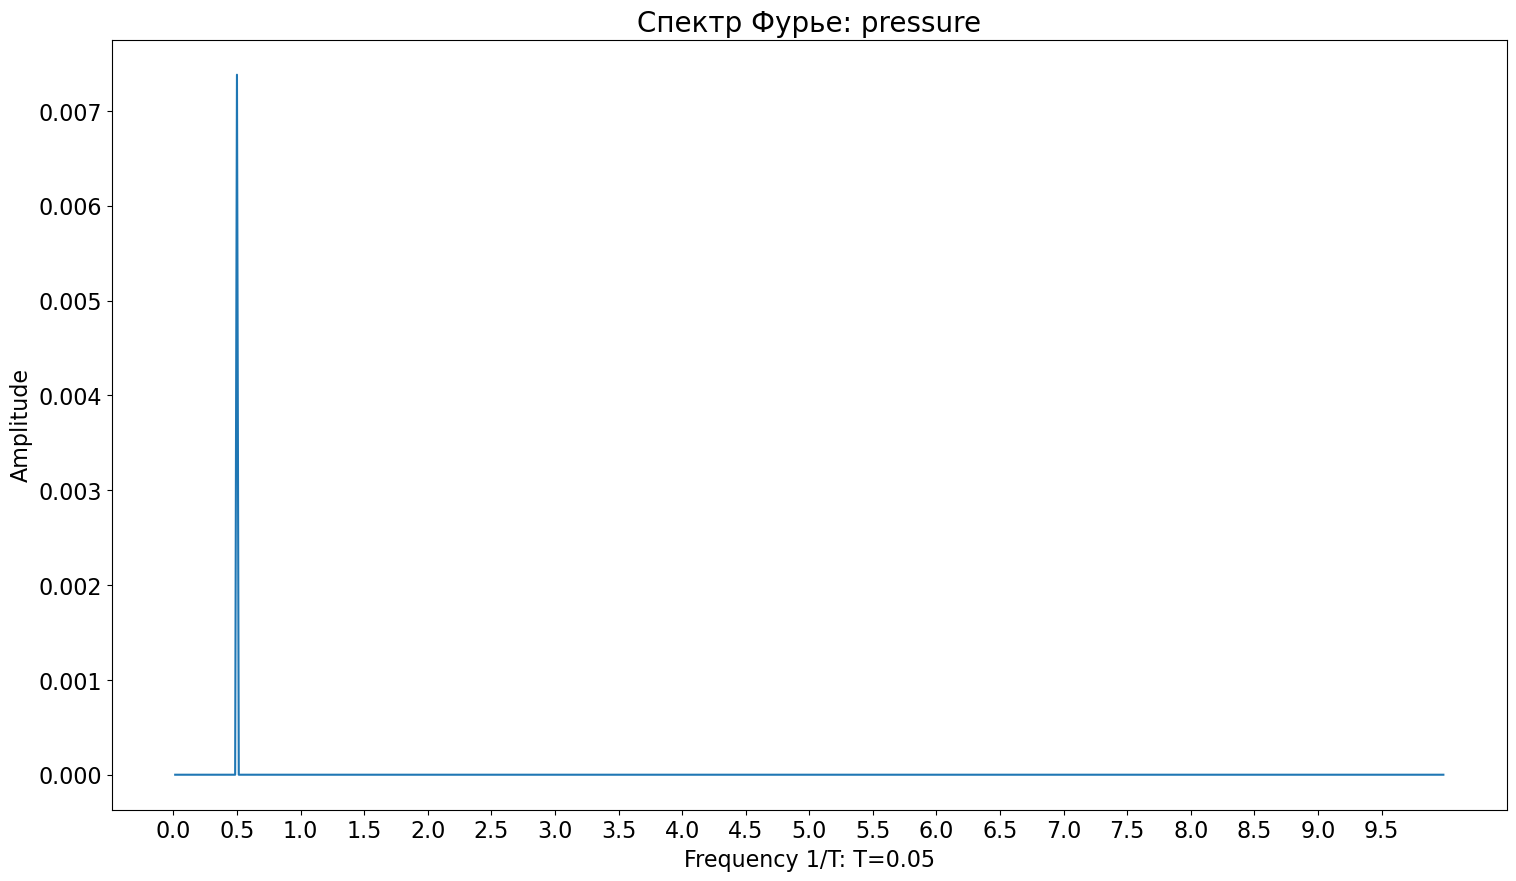

In [113]:
r_mean = np.mean(r_interp)
r_interp_centered = r_interp - r_mean

# получение спектра Фурье
r_fft = np.fft.fft(r_interp_centered)

# перемещение отрицательных частот в начало массива
r_fft_shifted = np.fft.fftshift(r_fft)

# отображение только второй половины массива
N = len(r_fft)
freq = np.fft.fftfreq(N, d=t_step)
freq_shifted = np.fft.fftshift(freq)

mask = freq_shifted > 0
freq_pos = freq_shifted[mask]
r_fft_pos = 2.0/N * np.abs(r_fft_shifted[mask])
r_fft_pos[abs(r_fft_pos) < 0.002] = 0


fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)


r_fft_pos[abs(r_fft_pos) < 0.002] = 0
plt.plot(freq_pos, r_fft_pos)


ax.set_xlabel('Frequency 1/T' +  ": T=" + str(round(t_step, 3)), fontsize=16)
ax.set_ylabel('Amplitude', fontsize=16)
plt.xticks(np.arange(0, max(freq_pos), 0.5), fontsize=16)
plt.title("Спектр Фурье: " + parameters[parameter], fontsize=20)
plt.yticks(fontsize=16)
# plt.xlim(0, 4)
plt.show(block=False)
plt.close()


In [116]:
def get_fourier(parameter) :
    x_point = 0.26
    r_interp = []
    
    t_min = sorted_data['t'].min()
    t_max = sorted_data['t'].max()
    t_interp = np.linspace(t_min, t_max, len(data['t'].unique()))
    t_step = t_interp[1] - t_interp[0]
    for t in t_interp:
        # выбрать ближайшие точки из отфильтрованных данных
        nearest_points = filtered_data[filtered_data['t'].between(t-t_step, t+t_step)]
    #     print(nearest_points)
        # выполнить линейную интерполяцию значений r на выбранном интервале времени
        try:
            interp_func = interp1d(nearest_points['x'], nearest_points[parameter], kind='linear', fill_value="extrapolate")
        except ValueError:
            print(nearest_points)
            break
        r_at_x_point = interp_func(x_point)
        r_interp.append(r_at_x_point)

    t_interp = t_interp[:len(r_interp)]
    
    r_mean = np.mean(r_interp)
    r_interp_centered = r_interp - r_mean

    # получение спектра Фурье
    r_fft = np.fft.fft(r_interp_centered)

    # перемещение отрицательных частот в начало массива
    r_fft_shifted = np.fft.fftshift(r_fft)

    # отображение только второй половины массива
    N = len(r_fft)
    freq = np.fft.fftfreq(N, d=t_step)
    freq_shifted = np.fft.fftshift(freq)

    mask = freq_shifted > 0
    freq_pos = freq_shifted[mask]
    r_fft_pos = 2.0/N * np.abs(r_fft_shifted[mask])
    r_fft_pos[abs(r_fft_pos) < 0.002] = 0
    
    return freq_pos, r_fft_pos

In [117]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# создаем фигуру с тремя подграфиками
fig = make_subplots(rows=1, cols=3, subplot_titles=("density", "velocity", "pressure"))

# добавляем данные на каждый подграфик
x, y = get_fourier("r")
fig.add_trace(go.Scatter(x=x, y=y, mode='lines'), row=1, col=1, )

x, y = get_fourier("u")
fig.add_trace(go.Scatter(x=x, y=y, mode='lines'), row=1, col=2)
x, y = get_fourier("p")
fig.add_trace(go.Scatter(x=x, y=y, mode='lines'), row=1, col=3)

# задаем заголовок и метки осей для всей фигуры
fig.update_layout(title_text="Спектр Фурье", xaxis_title="X", yaxis_title="Y")

# изменяем размер графиков
fig.update_layout(height=400, width=1600)
fig.update_xaxes(range=[0, 5], autorange=False)

fig.update_xaxes(dtick=0.5)
fig.update_traces(showlegend=False)


# выводим фигуру
fig.show()
fig.write_image(dir_name+"/plots/fourier_transform_" + str(x_point) + ".png")

In [118]:
import plotly.graph_objects as go

fig = go.Figure()

# добавляем вертикальные линии для правой части спектра Фурье
fig.add_trace(go.Scatter(x=freq_pos, y=r_fft_pos, mode='lines'))

# задаем заголовок и метки осей
fig.update_layout(title="Спектр Фурье: " + parameters[parameter], xaxis_title='Frequency', yaxis_title='Amplitude')

fig.update_xaxes(range=[0, 5], autorange=False)
fig.update_layout(width=500, height=500)


# выводим график
fig.show()

fig.write_image(dir_name+"/plots/fourier_transform_" + parameters[parameter] + ".png")